## Семинар 7: "Методы оптимизации"

ФИО: Быстров Иван Дмитриевич

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.autograd import Variable
%matplotlib inline
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output

На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [2]:
class Optimizer:
    def __init__(self, parameters):
        self.parameters = list(parameters)

    def zero_grad(self):
        for param in self.parameters:
            if param.grad is not None:
                param.grad.zero_()      
  
    def step(self, F):
        loss = F()
        loss.backward()

class SGD(Optimizer):
    def __init__(self, parameters, lr=0.01):
        super().__init__(parameters)
        
        self.lr = lr
        
    def step(self, F):
        loss = F()
        loss.backward()
        
        with torch.no_grad():
            for param in self.parameters:
                param -= self.lr*param.grad
                
class Momentum(Optimizer):
    def __init__(self, parameters, lr=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.lr = lr
        self.gamma = gamma
        
        self.vs = [torch.zeros_like(param) for param in self.parameters]
        
    def step(self, F):
        loss = F()
        loss.backward()
        
        with torch.no_grad():
            for param, v in zip(self.parameters, self.vs):
                """
                v *= self.gamma
                v += self.lr * param.grad
                """
                
                v.set_(self.gamma * v + self.lr * param.grad)
                
                param -= v
                
class NAG(Optimizer):
    def __init__(self, parameters, lr=0.01, gamma=0.9):
        super().__init__(parameters)
        
        self.lr = lr
        self.gamma = gamma
        
        self.vs = [torch.zeros_like(param) for param in self.parameters]
        
    def step(self, F):
        with torch.no_grad():
            for param, v in zip(self.parameters, self.vs):
                param -= self.gamma * v

        loss = F()
        loss.backward()
        
        with torch.no_grad():
            for param, v in zip(self.parameters, self.vs):
                param += self.gamma * v
                
                v.set_(self.gamma * v + self.lr * param.grad)
                
                param -= v
                
class Adagrad(Optimizer):
    def __init__(self, parameters, lr=0.01, gamma=0.9, eps=1e-8):
        super().__init__(parameters)
        
        self.lr = lr
        self.gamma = gamma
        
        self.eps = eps
        
        self.Gs = [torch.zeros_like(param) for param in self.parameters]
        
    def step(self, F):
        loss = F()
        loss.backward()
        
        with torch.no_grad():
            for param, G in zip(self.parameters, self.Gs):
                G += param.grad**2
                
                param -= self.lr / torch.sqrt(G + self.eps) * param.grad
                
class RMSProp(Optimizer):
    def __init__(self, parameters, lr=0.01, gamma=0.9, eps=1e-8):
        super().__init__(parameters)
        
        self.lr = lr
        self.gamma = gamma
        
        self.eps = eps
        
        self.Gs = [torch.zeros_like(param) for param in self.parameters]
    
    def step(self, F):
        loss = F()
        loss.backward()
        
        with torch.no_grad():
            for param, G in zip(self.parameters, self.Gs):
                G *= self.gamma
                G += (1 - self.gamma) * param.grad**2
                
                param -= self.lr / torch.sqrt(G + self.eps) * param.grad
                
class Adadelta(Optimizer):
    def __init__(self, parameters, lr=0.01, gamma=0.9, eps = 1e-8):
        super().__init__(parameters)
        
        self.lr = lr
        self.gamma = gamma
        
        self.eps = eps
        
        self.Gs = [torch.zeros_like(param) for param in self.parameters]
        self.dlt = [torch.zeros_like(param) for param in self.parameters]
    
    def step(self, F):
        loss = F()
        loss.backward()
        
        with torch.no_grad():
            for param, G, dlt in zip(self.parameters, self.Gs, self.dlt):
                G *= self.gamma
                G += (1 - self.gamma) * param.grad**2
                
                upd = torch.sqrt(dlt + self.eps) / torch.sqrt(G + self.eps) * param.grad
                
                dlt *= self.gamma
                dlt += (1 - self.gamma) * upd**2

                param -= upd
                
class Adam(Optimizer):
    def __init__(self, parameters, lr=0.01, b1=0.9, b2=0.999, eps=1e-8):
        super().__init__(parameters)
        
        self.lr = lr
        
        self.b1 = b1
        self.b2 = b2
        
        self.eps = eps
        
        self.Ms = [torch.zeros_like(param) for param in self.parameters]
        self.Vs = [torch.zeros_like(param) for param in self.parameters]
        
        self.iterations = 1
    
    def step(self, F):
        loss = F()
        loss.backward()
        
        with torch.no_grad():
            for param, m, v in zip(self.parameters, self.Ms, self.Vs):
                m.set_(self.b1 * m + (1 - self.b1) * param.grad)
                v.set_(self.b2 * v + (1 - self.b2) * param.grad**2)
                
                m_hat = m / (1 - self.b1**self.iterations)
                v_hat = v / (1 - self.b2**self.iterations)
                
                param -= self.lr / torch.sqrt(v_hat + self.eps) * m_hat
                
        self.iterations +=1

In [3]:
def calc(func):
    J = func
    optimizers = [SGD, Momentum, NAG, RMSProp, Adagrad, Adadelta, Adam]

    RESULTS = []
    flag = 0
    for opt in optimizers:
        v = torch.from_numpy(np.array([-1,4], dtype=float))
        v.requires_grad = True
        lr = 0.001

        if opt == Adagrad:
            lr = 1
        
        if opt == Adam:
            lr = 0.1
        
        if opt == RMSProp:
            lr = 0.1
        
        if opt == Adadelta:
            lr = 0.1

        opt = opt([v], lr)
    
        path = []
        for i in range(1000):
            opt.zero_grad()
            opt.step(lambda v=v: J(v[0], v[1]))
        
            z = J(v[0], v[1])
        
            path.append(list(v.detach().numpy()) +[z.item()])
        path = np.array(path)
        final_value = J(v[0], v[1])
        print(opt.__class__.__name__, final_value.item())
        RESULTS.append((final_value, path))
        
    return optimizers, RESULTS

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [4]:
def J1(x, y):
    return x**2 + y**2

optimizers, RESULTS = calc(J1)

SGD 0.310121228803762
Momentum 1.8528229133281142e-22
NAG 1.1446290449881141e-21
RMSProp 0.004999995000000004
Adagrad 4.188636351679281e-142
Adadelta 10.917206942799316
Adam 3.3133529223334355e-45


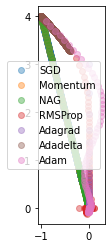

In [5]:
plt.axes().set_aspect('equal')
for opt, (final_value, path) in zip(optimizers, RESULTS):
    plt.scatter(path[:, 0], path[:, 1], label=opt.__name__, alpha=0.4)
plt.legend()

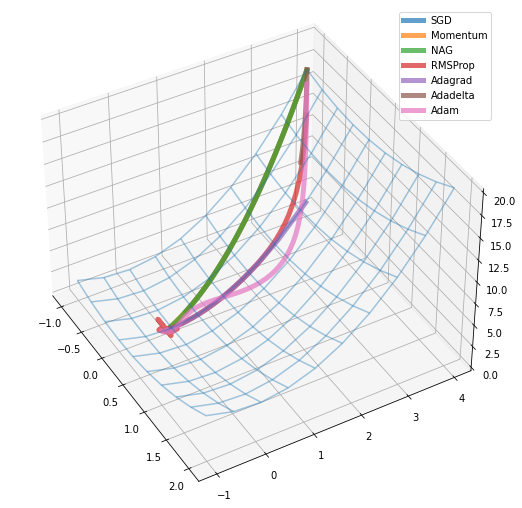

In [6]:
N=10

X = np.linspace(-1, 2, N).repeat(N).reshape(N, N)
Y = np.linspace(-1, 4, N).repeat(N).reshape(N, N).T

Z = J1(torch.from_numpy(X), torch.from_numpy(Y)).numpy()

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')

ax.plot_wireframe(X, Y, Z, alpha = 0.4)

for opt, (final_value, path) in zip(optimizers, RESULTS):
    ax.plot(path[:, 0], path[:, 1], path[:, 2], label=opt.__name__, alpha=0.7, linewidth=5)

ax.legend()

ax.view_init(40, -30)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [7]:
def J2(x, y):
    return x**2 * x.sin() + y**2 * y.sin()

optimizers, RESULTS = calc(J2)

SGD -28.028251199913324
Momentum -28.028261848352656
NAG -28.028261848352656
RMSProp -27.980201397195714
Adagrad -28.028261848352656
Adadelta -25.235202729772777
Adam -28.028261848352656


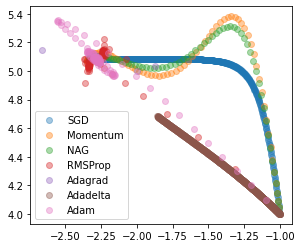

In [8]:
plt.axes().set_aspect('equal')
for opt, (final_value, path) in zip(optimizers, RESULTS):
    plt.scatter(path[:, 0], path[:, 1], label=opt.__name__, alpha=0.4)
plt.legend()

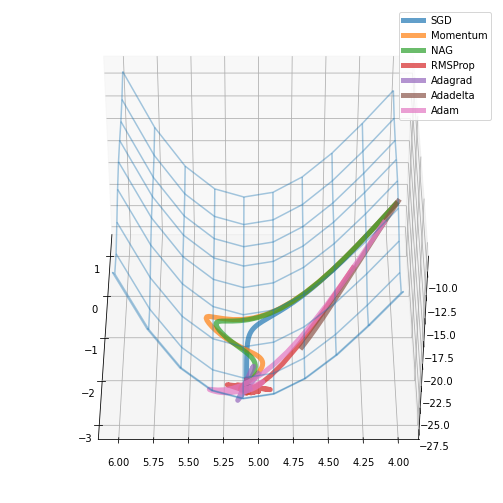

In [9]:
N=10

X = np.linspace(-3, 1.25, N).repeat(N).reshape(N, N)
Y = np.linspace(4, 6, N).repeat(N).reshape(N, N).T
Z = J2(torch.from_numpy(X), torch.from_numpy(Y)).numpy()

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')


for opt, (final_value, path) in zip(optimizers, RESULTS):
    ax.plot(path[:, 0], path[:, 1], path[:, 2], label=opt.__name__, alpha=0.7, linewidth=5)
ax.plot_wireframe(X, Y, Z, alpha = 0.4)
ax.legend()

ax.view_init(40, 180)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [10]:
def J3(x, y):
    return x**2 * (x**2).sin() + y**2 * (y**2).sin()

optimizers, RESULTS = calc(J3)

SGD -17.294373637252125
Momentum -17.30747305372746
NAG -17.307470865189675
RMSProp -15.733402757836082
Adagrad -17.307608607858512
Adadelta -17.249616483341896
Adam -17.307608564939592


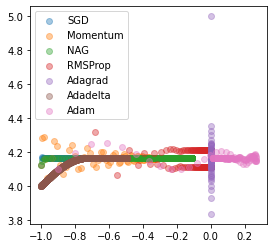

In [11]:
plt.axes().set_aspect('equal')
for opt, (final_value, path) in zip(optimizers, RESULTS):
    plt.scatter(path[:, 0], path[:, 1], label=opt.__name__, alpha=0.4)
plt.legend()

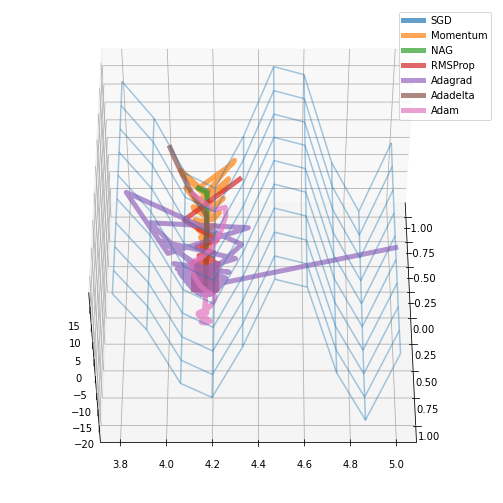

In [12]:
N=10

X = np.linspace(-1, 1, N).repeat(N).reshape(N, N)
Y = np.linspace(3.8, 5, N).repeat(N).reshape(N, N).T
Z = J3(torch.from_numpy(X), torch.from_numpy(Y)).numpy()

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(111, projection='3d')


for opt, (final_value, path) in zip(optimizers, RESULTS):
    ax.plot(path[:, 0], path[:, 1], path[:, 2], label=opt.__name__, alpha=0.7, linewidth=5)
ax.plot_wireframe(X, Y, Z, alpha = 0.4)
ax.legend()

ax.view_init(50, 0)

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). Для обучения используйте оптимизаторы из первой части, а не из pytorch. </i>

In [13]:
transform = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

C:\Users\Taireirmorion\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [14]:
def train(network, epochs, opt, learning_rate):
    loss = nn.NLLLoss()
    optimizer = opt(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in tqdm(train_loader):
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                optimizer.step(lambda: loss(prediction, y))
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

In [15]:
#Нейронная сверточная сеть из домашки 4
#input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax
image_size = 28
channels = 1
class ConvClassifier_1(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, (3, 3), padding=1), 
                                         nn.ReLU(),
                                         nn.Conv2d(8, 16, (3, 3), padding=1),
                                         nn.ReLU(),
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, (3, 3), padding=1))
        self.linear_layers = nn.Sequential(nn.Linear(6272, 10), nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.228/0.193	Accuracy: 0.934/0.942


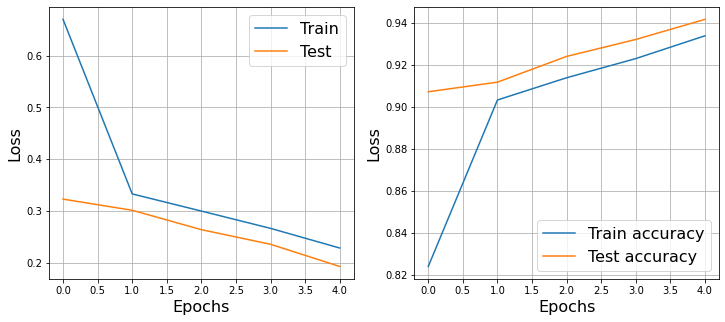

In [16]:
Net = ConvClassifier_1(image_size=28)
train(Net, 5, SGD, 0.001)

Epoch 4... (Train/Test) NLL: 0.187/0.142	Accuracy: 0.952/0.964


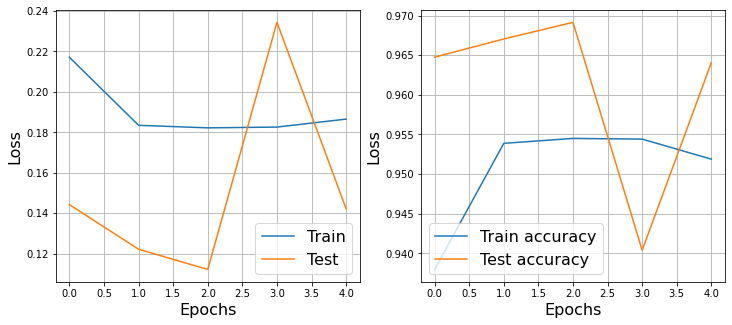

In [17]:
Net = ConvClassifier_1(image_size=28)
train(Net, 5, Adam, 0.01)

Epoch 4... (Train/Test) NLL: 0.105/0.102	Accuracy: 0.967/0.967


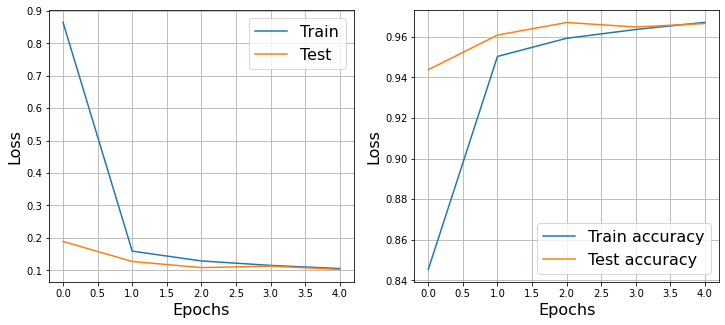

In [18]:
Net = ConvClassifier_1(image_size=28)
train(Net, 5, Adagrad, 0.1)

Epoch 4... (Train/Test) NLL: 0.050/0.047	Accuracy: 0.985/0.984


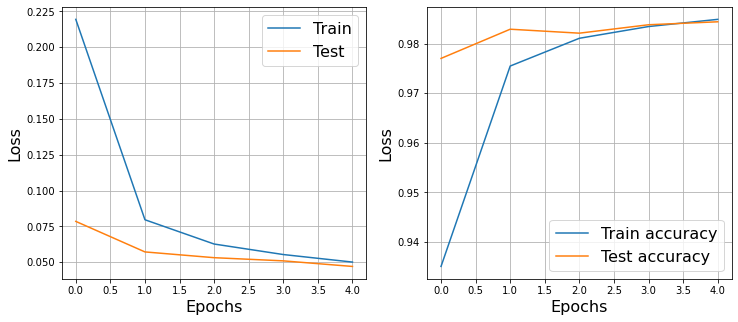

In [19]:
Net = ConvClassifier_1(image_size=28)
train(Net, 5, Adadelta, 0.1)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: